<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/knowledge_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
22-year ... nummod
- ... punct
old ... nsubj
recently ... advmod
won ... ROOT
ATP ... compound
Challenger ... compound
tournament ... dobj
. ... punct


In [2]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj
. ... punct


In [5]:

list_of_reviews = ["Healthy but because they taste good, it’s difficult to stop.",\
                   "Definitely has a brie texture and as much as I know it’s made of cashew like most vegan cheese, I can’t taste it. Tastes so incredibly good. Pretty sure I finished half the tub/container in one go.",\
                   "Pretty sure they’re keeping the recipe to their rendang in a vault, that I am going to break into! So so so good times a million!"]

for review in list_of_reviews:
  print('---')
  doc = nlp(review)
  print('---')
  for tok in doc:
    print(tok.text, "...", tok.dep_)


---
---
Healthy ... ROOT
but ... cc
because ... mark
they ... nsubj
taste ... advcl
good ... dobj
, ... punct
it ... nsubj
’s ... conj
difficult ... acomp
to ... aux
stop ... xcomp
. ... punct
---
---
Definitely ... advmod
has ... ROOT
a ... det
brie ... amod
texture ... dobj
and ... cc
as ... advmod
much ... conj
as ... mark
I ... nsubj
know ... advcl
it ... dobj
’s ... nsubj
made ... ROOT
of ... prep
cashew ... pobj
like ... intj
most ... amod
vegan ... compound
cheese ... pobj
, ... punct
I ... nsubj
ca ... aux
n’t ... neg
taste ... ROOT
it ... dobj
. ... punct
Tastes ... nsubj
so ... advmod
incredibly ... advmod
good ... ROOT
. ... punct
Pretty ... advmod
sure ... advmod
I ... nsubj
finished ... ROOT
half ... predet
the ... det
tub ... nmod
/ ... punct
container ... dobj
in ... prep
one ... nummod
go ... pobj
. ... punct
---
---
Pretty ... advmod
sure ... ROOT
they ... nsubj
’re ... nsubj
keeping ... ccomp
the ... det
recipe ... dobj
to ... prep
their ... poss
rendang ... pobj
in .

In [0]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [0]:
from urllib.request import urlretrieve

In [9]:
url = "https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/10/wiki_sentences_v2.csv"
urlretrieve(url,'wiki_sentences_v2.csv')


# import wikipedia sentences
candidate_sentences = pd.read_csv("wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [10]:
candidate_sentences['sentence'].sample(5)

40           dougherty also changed, revised, and improved lines during filming and post-production.
1203                           rajkumar hirani is without a doubt their most worthy standard-bearer.
4011    the first film to be released with this rating was the 1984 john milius war film red dawn.  
833                      24×36 mm exposures seems to be the simplex, introduced in the u.s. in 1914.
2333             rampant is a 2018 south korean period action zombie film directed by kim sung-hoon.
Name: sentence, dtype: object

In [11]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... compound
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... pobj
d823 ... punct


In [0]:

def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

**Chunk 1**

I have defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

**Chunk 2**

Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

**Chunk 3**

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

**Chunk 4**

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

**Chunk 5**

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

In [13]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [14]:
get_entities("Healthy but because they taste good, it’s difficult to stop.")

['it', 'good']

In [15]:
get_entities("Pretty sure they’re keeping the recipe to their rendang in a vault, that I am going to break into! So so so good times a million!")

['I', 'vault']

In [16]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:46<00:00, 92.93it/s]


In [17]:
entity_pairs[10:20]

[['we', 'tests'],
 ['global', 'international sales rights'],
 ['robbie  robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'sequel']]

In [19]:
candidate_sentences['sentence'][10:20]

10                                       we went through all these tests and things  
11       m global was also circling to bid for the film's international sales rights.
12                      canadian musician robbie robertson supervised the soundtrack.
13                               it features both original and existing music tracks.
14                                    it is the worst reviewed film in the franchise.
15    but she injures quicksilver and accidentally kills mystique before flying away.
16                                            military forces tasked with her arrest.
17                                the train is attacked by vuk and her d'bari forces.
18                                    kota eberhardt portrays telepath selene gallio,
19                                 singer did not return to direct the sequel, x-men:
Name: sentence, dtype: object

In [0]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [21]:
get_relation("John completed the task")

'completed'

In [22]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:46<00:00, 92.37it/s]


In [23]:
pd.Series(relations).value_counts()[:50]

is               368
was              283
released on       79
are               72
include           69
were              63
's                42
released          41
has               30
have              30
became            29
composed by       29
released in       28
become            28
considered        22
included          21
had               19
be                19
called            19
produced          19
been              18
used              18
stars             18
scheduled         17
made              16
directed by       15
set               14
hired             14
went              14
wrote             14
received          13
written by        13
introduced in     13
sold              12
wanted            12
won               11
cast as           11
produced by       10
includes          10
began             10
gave              10
began in          10
features          10
gives              9
used in            9
shot in            9
directed           9
opened       

In [0]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [0]:

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

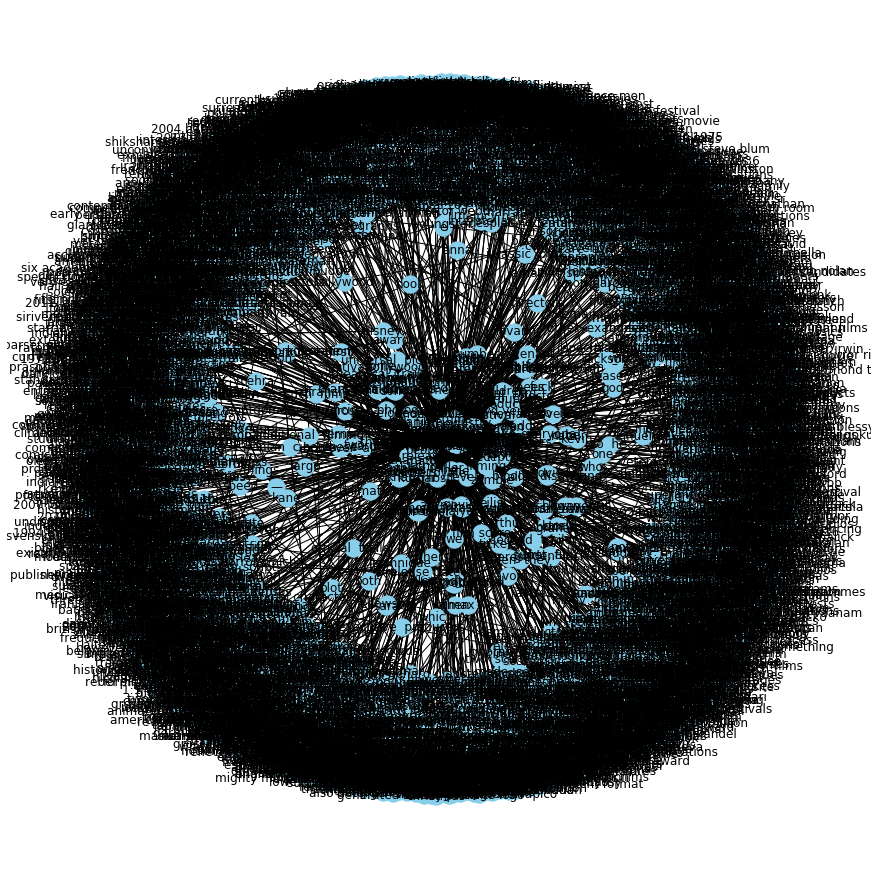

In [26]:

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

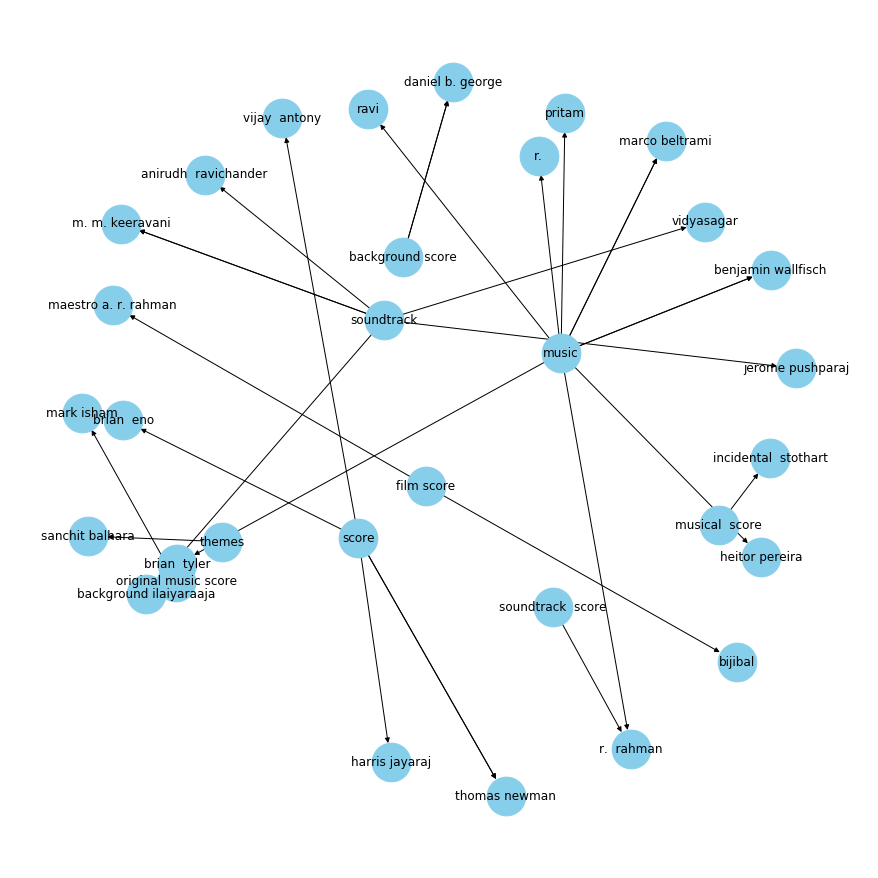

In [27]:

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

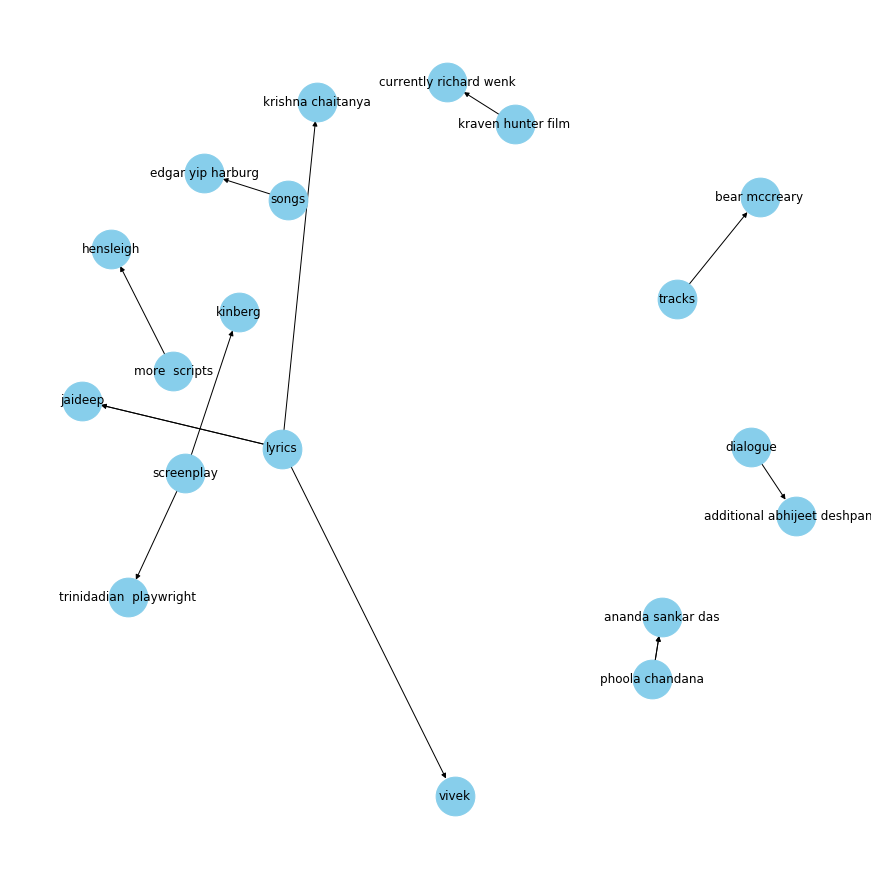

In [28]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

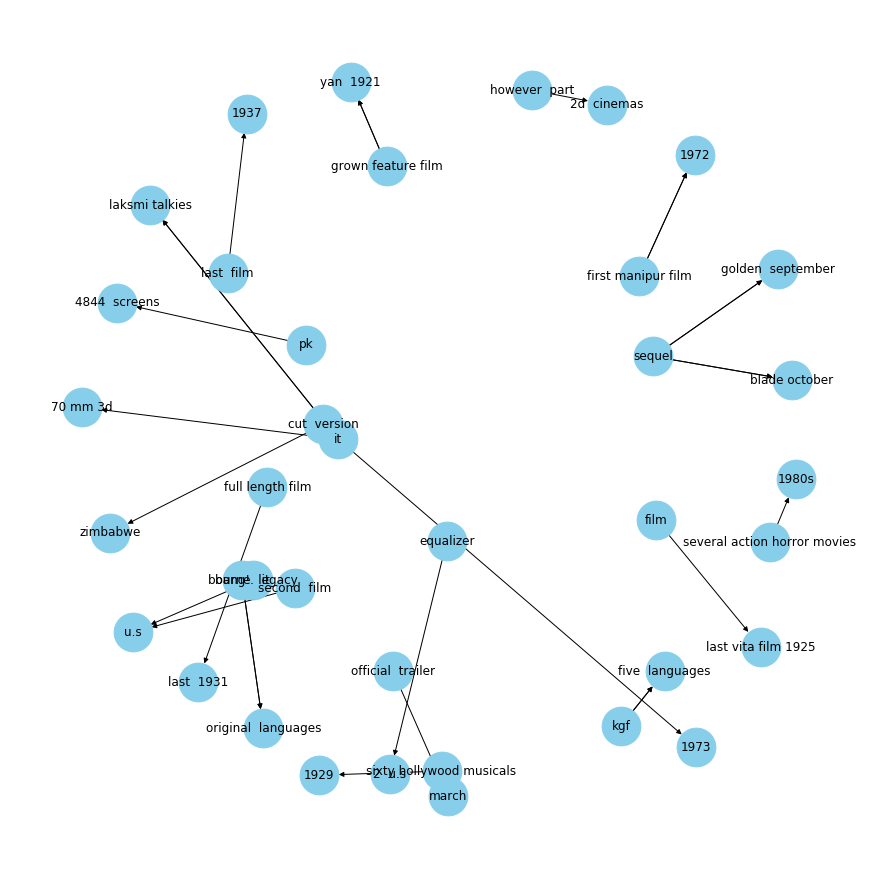

In [29]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()